In [1]:
# Importamos la librería Pandas

import pandas as pd

In [2]:
# Cargamos los datasets

FullData = pd.read_csv("../data/f17/FullData.csv", encoding = "utf8")
PlayerNames = pd.read_csv("../data/f17/PlayerNames.csv", encoding = "utf8")
complete = pd.read_csv("../data/f18/complete.csv", encoding = 'utf8')
ClubNames = pd.read_csv("../data/f17/ClubNames.csv", encoding = 'utf8')

PlayerNames.head()

,Name,url
0,Cristiano Ronaldo,/player/20801/cristiano-ronaldo/
1,Lionel Messi,/player/158023/lionel-messi/
2,Neymar,/player/190871/neymar/
3,Luis Suárez,/player/176580/luis-su%C3%A1rez/
4,Manuel Neuer,/player/167495/manuel-neuer/


In [3]:
# Obtenemos el ID de los jugadores y lo cruzamos con el dataset completo de 2017
# Esto nos permitirá cruzarlos con el dataset de 2018

PlayerNames["ID"] = PlayerNames.url.str.rsplit('/').apply(lambda x:x[2])

FullDataMod = pd.merge(FullData, PlayerNames, on="Name", how="inner")

# Descomponemos los atributos de work_rate en 2017 para asemejarlos al dataset de 2018
FullDataMod["work_rate_att"] = FullDataMod.Work_Rate.str.rsplit('/').apply(lambda x:x[0]).str.strip()
FullDataMod["work_rate_def"] = FullDataMod.Work_Rate.str.rsplit('/').apply(lambda x:x[1]).str.strip()

FullDataMod.head()

,Name,Nationality,National_Position,National_Kit,Club,Club_Position,Club_Kit,Club_Joining,Contract_Expiry,Rating,...,Volleys,GK_Positioning,GK_Diving,GK_Kicking,GK_Handling,GK_Reflexes,url,ID,work_rate_att,work_rate_def
0,Cristiano Ronaldo,Portugal,LS,7.0,Real Madrid,LW,7.0,07/01/2009,2021.0,94,...,88,14,7,15,11,11,/player/20801/cristiano-ronaldo/,20801,High,Low
1,Lionel Messi,Argentina,RW,10.0,FC Barcelona,RW,10.0,07/01/2004,2018.0,93,...,85,14,6,15,11,8,/player/158023/lionel-messi/,158023,Medium,Medium
2,Neymar,Brazil,LW,10.0,FC Barcelona,LW,11.0,07/01/2013,2021.0,92,...,83,15,9,15,9,11,/player/190871/neymar/,190871,High,Medium
3,Luis Suárez,Uruguay,LS,9.0,FC Barcelona,ST,9.0,07/11/2014,2021.0,92,...,88,33,27,31,25,37,/player/176580/luis-su%C3%A1rez/,176580,High,Medium
4,Manuel Neuer,Germany,GK,1.0,FC Bayern,GK,1.0,07/01/2011,2021.0,92,...,11,91,89,95,90,89,/player/167495/manuel-neuer/,167495,Medium,Medium


In [4]:
# Comprobamos que el join anterior duplica registros. Esto se debe a jugadores que tienen el mismo nombre,
# por ejemplo, J. Jones. Eliminamos estos registros para no afectar al modelo

print len(FullDataMod) - len(FullData)
FullDataMod = FullDataMod.drop_duplicates(subset=["Name"])
print len(FullDataMod) - len(FullData) 

600
-247


In [5]:
# En el dataset de 2017, creamos los campos de position y work_rate_int

def position_17(df):
  if ("GK" in df["Preffered_Position"]):
    return 'gk'
  elif ("CB" in df["Preffered_Position"]):
    return 'cb'
  elif ("RB" in df["Preffered_Position"]) | ("LB" in df["Preffered_Position"]) | ("RWB" in df["Preffered_Position"]) | ("LWB" in df["Preffered_Position"]):
    return 'wb'
  elif ("CDM" in df["Preffered_Position"]) | ("CM" in df["Preffered_Position"]) | ("CAM" in df["Preffered_Position"]):
    return 'mid'
  elif ("LM" in df["Preffered_Position"]) | ("RM" in df["Preffered_Position"]) | ("LW" in df["Preffered_Position"]) | ("RW" in df["Preffered_Position"]):
    return 'wing'
  elif ("ST" in df["Preffered_Position"]) | ("CF" in df["Preffered_Position"]):
    return 'st'
  else:
    return 'oth'

def position_17_int(df):
  if ("GK" in df["Preffered_Position"]):
    return 1
  elif ("CB" in df["Preffered_Position"]):
    return 2
  elif ("RB" in df["Preffered_Position"]) | ("LB" in df["Preffered_Position"]) | \
    ("RWB" in df["Preffered_Position"]) | ("LWB" in df["Preffered_Position"]):
    return 3
  elif ("CDM" in df["Preffered_Position"]) | ("RDM" in df["Preffered_Position"]) | ("LDM" in df["Preffered_Position"]) | \
    ("CM" in df["Preffered_Position"]) | ("RCM" in df["Preffered_Position"]) | ("LCM" in df["Preffered_Position"]) | \
    ("LM" in df["Preffered_Position"]) | ("RM" in df["Preffered_Position"]):
    return 4
  elif ("LAM" in df["Preffered_Position"]) | ("RAM" in df["Preffered_Position"]) | ("CAM" in df["Preffered_Position"]):
    return 5
  elif ("LW" in df["Preffered_Position"]) | ("RW" in df["Preffered_Position"]):
    return 6
  elif ("ST" in df["Preffered_Position"]) | ("CF" in df["Preffered_Position"]) | ("LF" in df["Preffered_Position"]) | \
    ("RF" in df["Preffered_Position"]) | ("LS" in df["Preffered_Position"]) | ("RS" in df["Preffered_Position"]):
    return 7
  else:
    return 8

def work_rate_att_17_int(df):
  if (df["work_rate_att"] == "Low"):
    return 1
  elif (df["work_rate_att"] == "Medium"):
    return 2
  elif (df["work_rate_att"] == "High"):
    return 3
  else:
    return 0

def work_rate_def_17_int(df):
  if (df["work_rate_def"] == "Low"):
    return 1
  elif (df["work_rate_def"] == "Medium"):
    return 2
  elif (df["work_rate_def"] == "High"):
    return 3
  else:
    return 0

FullDataMod["position"] = FullDataMod.apply(position_17, axis=1)
FullDataMod["position_int"] = FullDataMod.apply(position_17_int, axis=1)
FullDataMod["work_rate_att_int"] = FullDataMod.apply(work_rate_att_17_int, axis=1)
FullDataMod["work_rate_def_int"] = FullDataMod.apply(work_rate_def_17_int, axis=1)

In [6]:
# En el dataset de 2018, creamos los campos de position y work_rate_int
# Creamos otra variable para usar en el modelo: el índice de masa muscular
# Más adelante también la creamos en el dataset de 2017

def position(df):
  if (df["prefers_gk"] == True):
    return 'gk'
  elif (df["prefers_cb"] == True) | (df["prefers_lcb"] == True) | (df["prefers_rcb"] == True):
    return 'cb'
  elif (df["prefers_rb"] == True) | (df["prefers_lb"] == True) | (df["prefers_rwb"] == True) | \
  (df["prefers_lwb"] == True):
    return 'wb'
  elif (df["prefers_cdm"] == True) | (df["prefers_rdm"] == True) | (df["prefers_ldm"] == True) | \
  (df["prefers_cm"] == True) | (df["prefers_rcm"] == True) | (df["prefers_lcm"] == True) | \
  (df["prefers_lm"] == True) | (df["prefers_rm"] == True):
    return 'mid'
  elif (df["prefers_lam"] == True) | (df["prefers_ram"] == True) | (df["prefers_cam"] == True):
    return "f_mid"
  elif (df["prefers_lw"] == True) | (df["prefers_rw"] == True):
    return 'wing'
  elif (df["prefers_st"] == True) | (df["prefers_cf"] == True) | (df["prefers_lf"] == True) | \
  (df["prefers_rf"] == True) | (df["prefers_ls"] == True) | (df["prefers_rs"] == True):
    return 'st'
  else:
    return 'oth'

def position_int(df):
  if (df["prefers_gk"] == True):
    return 1
  elif (df["prefers_cb"] == True) | (df["prefers_lcb"] == True) | (df["prefers_rcb"] == True):
    return 2
  elif (df["prefers_rb"] == True) | (df["prefers_lb"] == True) | (df["prefers_rwb"] == True) | \
  (df["prefers_lwb"] == True):
    return 3
  elif (df["prefers_cdm"] == True) | (df["prefers_rdm"] == True) | (df["prefers_ldm"] == True) | \
  (df["prefers_cm"] == True) | (df["prefers_rcm"] == True) | (df["prefers_lcm"] == True) | \
  (df["prefers_lm"] == True) | (df["prefers_rm"] == True):
    return 4
  elif (df["prefers_lam"] == True) | (df["prefers_ram"] == True) | (df["prefers_cam"] == True):
    return 5
  elif (df["prefers_lw"] == True) | (df["prefers_rw"] == True):
    return 6
  elif (df["prefers_st"] == True) | (df["prefers_cf"] == True) | (df["prefers_lf"] == True) | \
  (df["prefers_rf"] == True) | (df["prefers_ls"] == True) | (df["prefers_rs"] == True):
    return 7
  else:
    return 8

def work_rate_att_int(df):
  if (df["work_rate_att"] == "Low"):
    return 1
  elif (df["work_rate_att"] == "Medium"):
    return 2
  elif (df["work_rate_att"] == "High"):
    return 3
  else:
    return 0

def work_rate_def_int(df):
  if (df["work_rate_def"] == "Low"):
    return 1
  elif (df["work_rate_def"] == "Medium"):
    return 2
  elif (df["work_rate_def"] == "High"):
    return 3
  else:
    return 0

complete["position"] = complete.apply(position, axis=1)
complete["position_int"] = complete.apply(position_int, axis=1)
complete["work_rate_att_int"] = complete.apply(work_rate_att_int, axis=1)
complete["work_rate_def_int"] = complete.apply(work_rate_def_int, axis=1)
complete["imc"] = complete["weight_kg"] / complete["height_cm"]

In [7]:
# Seleccionamos los campos con los que vamos a trabajar en los distintos datasets

interesting_columns_17 = ["ID", "Height", "Weight", "Preffered_Foot", "Age", "work_rate_att_int", "work_rate_def_int",
                          "Weak_foot", "Skill_Moves", "Ball_Control", "Dribbling", "Marking", "Sliding_Tackle", 
                          "Standing_Tackle", "Aggression", "Reactions", "Interceptions", "Vision", "Composure", "Crossing", 
                          "Short_Pass", "Long_Pass", "Acceleration", "Speed", "Stamina", "Strength", "Balance", "Agility", 
                          "Jumping", "Heading", "Shot_Power", "Finishing", "Long_Shots", "Curve", "Freekick_Accuracy", 
                          "Penalties", "Volleys", "GK_Positioning", "GK_Diving", "GK_Kicking", "GK_Handling", "GK_Reflexes", 
                          "position_int", "Rating"
                          ]

new_columns_17 = ["ID", "height_cm", "weight_kg", "preferred_foot", "age", "work_rate_att_int", "work_rate_def_int",
                  "weak_foot", "skill_moves", "ball_control", "dri", "marking", 
                  "sliding_tackle", "standing_tackle", "aggression", "reactions", "interceptions", "vision", 
                  "composure", "crossing", "long_passing", "short_passing", "acceleration", "sprint_speed", "stamina", "strength", 
                  "balance", "agility", "jumping", "heading_accuracy", "shot_power", "finishing", "long_shots", 
                  "curve", "free_kick_accuracy", "penalties", "volleys", "gk_positioning", "gk_diving", "gk_kicking", 
                  "gk_handling", "gk_reflexes", "position_int", "overall"
                  ]

overall_join_18 = ["ID", "overall"]

interesting_columns_18 = ["ID", "club", "height_cm", "weight_kg", "imc", "preferred_foot", "age", "work_rate_att_int", "work_rate_def_int",  
                          "weak_foot", "skill_moves", "ball_control", "dri", "marking", 
                          "sliding_tackle", "standing_tackle", "aggression", "reactions", "interceptions", "vision", 
                          "composure", "crossing", "long_passing", "short_passing", "acceleration", "sprint_speed", "stamina", "strength", 
                          "balance", "agility", "jumping", "heading_accuracy", "shot_power", "finishing", "long_shots", 
                          "curve", "free_kick_accuracy", "penalties", "volleys", "gk_positioning", "gk_diving", "gk_kicking", 
                          "gk_handling", "gk_reflexes", "position_int", "overall", "eur_value"
                          ]


In [8]:
# Preparamos el dataset de 2017 sin NAs

df17 = FullDataMod[interesting_columns_17].copy()
df17 = df17.fillna(0)
df17.columns = new_columns_17
df17.head()

,ID,height_cm,weight_kg,preferred_foot,age,work_rate_att_int,work_rate_def_int,weak_foot,skill_moves,ball_control,...,free_kick_accuracy,penalties,volleys,gk_positioning,gk_diving,gk_kicking,gk_handling,gk_reflexes,position_int,overall
0,20801,185 cm,80 kg,Right,32,3,1,4,5,93,...,76,85,88,14,7,15,11,11,6,94
1,158023,170 cm,72 kg,Left,29,2,2,4,4,95,...,90,74,85,14,6,15,11,8,6,93
2,190871,174 cm,68 kg,Right,25,3,2,5,5,95,...,84,81,83,15,9,15,9,11,6,92
3,176580,182 cm,85 kg,Right,30,3,2,4,4,91,...,84,85,88,33,27,31,25,37,7,92
4,167495,193 cm,92 kg,Right,31,2,2,4,1,48,...,11,47,11,91,89,95,90,89,1,92


In [9]:
# Preparamos el dataset de 2018 sin NAs

df18 = complete[interesting_columns_18].copy()
df18.club = df18.club.fillna("unknown")
df18 = df18.fillna(0)

In [10]:
# Vemos los data types del dataset de 2017

df17.dtypes

ID                    object
height_cm             object
weight_kg             object
preferred_foot        object
age                    int64
work_rate_att_int      int64
work_rate_def_int      int64
weak_foot              int64
skill_moves            int64
ball_control           int64
dri                    int64
marking                int64
sliding_tackle         int64
standing_tackle        int64
aggression             int64
reactions              int64
interceptions          int64
vision                 int64
composure              int64
crossing               int64
long_passing           int64
short_passing          int64
acceleration           int64
sprint_speed           int64
stamina                int64
strength               int64
balance                int64
agility                int64
jumping                int64
heading_accuracy       int64
shot_power             int64
finishing              int64
long_shots             int64
curve                  int64
free_kick_accu

In [11]:
# Vemos ahora los data types del dataset de 2018

df18.dtypes

ID                      int64
club                   object
height_cm             float64
weight_kg             float64
imc                   float64
preferred_foot         object
age                     int64
work_rate_att_int       int64
work_rate_def_int       int64
weak_foot               int64
skill_moves             int64
ball_control            int64
dri                     int64
marking                 int64
sliding_tackle          int64
standing_tackle         int64
aggression              int64
reactions               int64
interceptions           int64
vision                  int64
composure               int64
crossing                int64
long_passing            int64
short_passing           int64
acceleration            int64
sprint_speed            int64
stamina                 int64
strength                int64
balance                 int64
agility                 int64
jumping                 int64
heading_accuracy        int64
shot_power              int64
finishing 

In [12]:
# Vemos la cabecera del dataset de 2017. Son necesarias ciertas transformaciones, como en la altura y peso de los jugadores
df17.head()

,ID,height_cm,weight_kg,preferred_foot,age,work_rate_att_int,work_rate_def_int,weak_foot,skill_moves,ball_control,...,free_kick_accuracy,penalties,volleys,gk_positioning,gk_diving,gk_kicking,gk_handling,gk_reflexes,position_int,overall
0,20801,185 cm,80 kg,Right,32,3,1,4,5,93,...,76,85,88,14,7,15,11,11,6,94
1,158023,170 cm,72 kg,Left,29,2,2,4,4,95,...,90,74,85,14,6,15,11,8,6,93
2,190871,174 cm,68 kg,Right,25,3,2,5,5,95,...,84,81,83,15,9,15,9,11,6,92
3,176580,182 cm,85 kg,Right,30,3,2,4,4,91,...,84,85,88,33,27,31,25,37,7,92
4,167495,193 cm,92 kg,Right,31,2,2,4,1,48,...,11,47,11,91,89,95,90,89,1,92


In [13]:
# Transformamos los campos necesarios en el dataset de 2017 para alinearlo con el de 2018 en cuan to a data types y formatos
# Creamos el imc

df17["ID"] = df17.ID.astype(int)
df17["height_cm"] = df17["height_cm"].str.replace(" cm", "").astype(float)
df17["weight_kg"] = df17["weight_kg"].str.replace(" kg", "").astype(float)
df17["imc"] = df17["weight_kg"] / df17["height_cm"]

In [14]:
# Adjuntamos al dataset de 2017 las puntuaciones de los jugadores en 2018

df_overall_join_18 = complete[overall_join_18].copy()
df_overall_join_18.columns = ["ID", "overall_pred"]

df17 = pd.merge(df17, df_overall_join_18, on = 'ID', how='inner')

In [15]:
# Comprobamos los data types del dataset de 2017

df17.dtypes

ID                      int32
height_cm             float64
weight_kg             float64
preferred_foot         object
age                     int64
work_rate_att_int       int64
work_rate_def_int       int64
weak_foot               int64
skill_moves             int64
ball_control            int64
dri                     int64
marking                 int64
sliding_tackle          int64
standing_tackle         int64
aggression              int64
reactions               int64
interceptions           int64
vision                  int64
composure               int64
crossing                int64
long_passing            int64
short_passing           int64
acceleration            int64
sprint_speed            int64
stamina                 int64
strength                int64
balance                 int64
agility                 int64
jumping                 int64
heading_accuracy        int64
shot_power              int64
finishing               int64
long_shots              int64
curve     

In [16]:
# Comprobamos la cabecera del dataset de 2017

df17.head()

,ID,height_cm,weight_kg,preferred_foot,age,work_rate_att_int,work_rate_def_int,weak_foot,skill_moves,ball_control,...,volleys,gk_positioning,gk_diving,gk_kicking,gk_handling,gk_reflexes,position_int,overall,imc,overall_pred
0,20801,185.0,80.0,Right,32,3,1,4,5,93,...,88,14,7,15,11,11,6,94,0.432432,94
1,158023,170.0,72.0,Left,29,2,2,4,4,95,...,85,14,6,15,11,8,6,93,0.423529,93
2,190871,174.0,68.0,Right,25,3,2,5,5,95,...,83,15,9,15,9,11,6,92,0.390805,92
3,176580,182.0,85.0,Right,30,3,2,4,4,91,...,88,33,27,31,25,37,7,92,0.467033,92
4,167495,193.0,92.0,Right,31,2,2,4,1,48,...,11,91,89,95,90,89,1,92,0.476684,92


In [17]:
# El objetivo del modelo es predecir el valor de overall del año siguiente.
# Para elegir las variables predictoras, creamos una matriz de correlación y vemos con cuáles nos quedamos

columns_corr = ["imc", "age", "work_rate_att_int", "work_rate_def_int",
                "weak_foot", "skill_moves", "ball_control", "dri", "marking",
                "sliding_tackle", "standing_tackle", "aggression", "reactions", "interceptions", "vision",
                "composure", "crossing", "long_passing", "short_passing", "acceleration", "sprint_speed", "stamina", 
                "strength","balance", "agility", "jumping", "heading_accuracy", "shot_power", "finishing", "long_shots",
                "curve", "free_kick_accuracy", "penalties", "volleys", "gk_positioning", "gk_diving", "gk_kicking",
                "gk_handling", "gk_reflexes", "position_int", "overall", "overall_pred"]

corr = df17[columns_corr].corr()
corr.style.background_gradient()

In [18]:
# Elegimos imc, age, overall (obvio: el overall del año actual), possition_int y dos variables
# que hemos visto que tienen una correlación importante: reactions y composure

data = ["imc", "age", "overall", "position_int", "reactions", "composure"]

target = ["overall_pred"]

In [19]:
# Cargamos las librerías sklearn necesarias (probamos varios modelos según la documentación de sklearn)
from sklearn.model_selection import train_test_split
from sklearn import linear_model
#from sklearn import svm
#from sklearn.linear_model import ElasticNet

# Creamos los datasets de training y test e instanciamos el modelo (Linear Regression)
X_train, X_test, y_train, y_test = train_test_split(df17[data], df17[target], test_size = 0.3)

overall_predictor = linear_model.LinearRegression(normalize = True)
#overall_predictor = ElasticNet(random_state=0)
#overall_predictor = linear_model.Ridge(alpha = .5)
#overall_predictor = linear_model.Lasso(alpha = 0.1)

#overall_predictor = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
#overall_predictor = svm.SVR(kernel='linear', C=1e3)
#overall_predictor = svm.SVR(kernel='poly', C=1e3, degree=2)

# Ajustamos el modelo
overall_predictor.fit(X_train, y_train)
#overall_predictor.fit(X_train, y_train.ravel())

# Aplicamos el modelo
overall_predictions = overall_predictor.predict(X_test)

In [20]:
# Comprobamos la predicción del modelo en la cabecera del conjunto de test
l = len(y_test)
index = range(0, l)

overall_df = y_test.copy()
overall_df.index = index
overall_df["predicted"] = overall_predictions
overall_df["error"] = abs(overall_df["overall_pred"] - overall_df["predicted"])
overall_df.head()

,overall_pred,predicted,error
0,61,62.280791,1.280791
1,66,65.421078,0.578922
2,70,70.494265,0.494265
3,68,68.078202,0.078202
4,84,82.643246,1.356754


In [21]:
# Calculamos el error medio, máximo y mínimo
print overall_df.error.mean()
print overall_df.error.max()
print overall_df.error.min()

1.22394782681
11.982595471
1.84486246582e-05


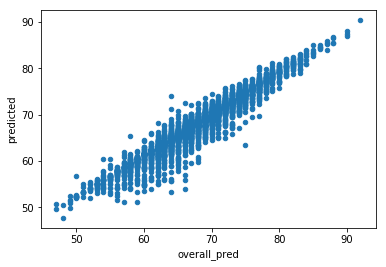

In [22]:
# Representamos los valores reales y estimados con matplotlib

%matplotlib inline
import matplotlib.pyplot as plt

overall_df.plot(kind = "scatter", x = "overall_pred", y = "predicted")
plt.show()

In [23]:
# Importamos la librería NumPy y las metrics de sklearn para comprobar mean squared error y variance score
import numpy as np 
from sklearn.metrics import mean_squared_error, r2_score 

print("Mean squared error: %.2f" % mean_squared_error(y_test, overall_predictions))
print('Variance score: %.2f' % r2_score(y_test, overall_predictions))

Mean squared error: 3.01
Variance score: 0.93


In [25]:
# Tomamos un ejemplo: Theo Hernández (el modelo dice que el año que viene mejorará el overall en 0.616)
complete_x = complete[data].copy()
fifa18_pred = overall_predictor.predict(complete_x)
complete["overall_pred"] = fifa18_pred
complete.iloc[1926][["name","age","overall","overall_pred"]]

name            T. Hernández
age                       19
overall                   75
overall_pred          75.616
Name: 1926, dtype: object

In [26]:
# Recorremos el dataset original con un bucle obteniendo las predicciones de cada futbolista

l = len(complete) 
index = range(0,l)
columns = ['ID_pred','overall_pred']
predictionsDF = pd.DataFrame(index=index, columns=columns)

listaJugadores = range(0, l)
for i in listaJugadores:
    predictionsDF.loc[i,'ID_pred'] = complete.loc[i,'ID']
    predictionsDF.loc[i,'overall_pred'] = complete.loc[i,'overall_pred']

In [27]:
# Escribimos el resultado en CSV
predictionsDF.to_csv('../data/output/overall_pred_2018.csv', sep=',', columns = columns, encoding='utf-8')